# MLP training using SMC

In [23]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from chex import ArrayDevice
from collections.abc import Callable
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
class MLP(nn.Module):
    n_hidden: int
    n_out: int
    activation: Callable[[ArrayDevice], ArrayDevice] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

    
def fz(W):
    return W


def f(x):
    return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle = jax.random.split(key, 3)
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    X = jnp.c_[x, y]

    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    X, y = jnp.array(X[shuffled_ixs, :].T)
    return X, y


def generate_train_test_data(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    x, y = sample_observations(key, f, n_obs, xmin, xmax, x_noise, y_noise)
    xtest = jnp.linspace(x.min(), x.max(), n_obs)
    return (x, y), (xtest, f(xtest))

In [67]:
key = jax.random.PRNGKey(314)
key_sample_obs, key_weights, key_params_init, key_smc = jax.random.split(key, 4)

Text(0.5, 1.0, 'Training data')

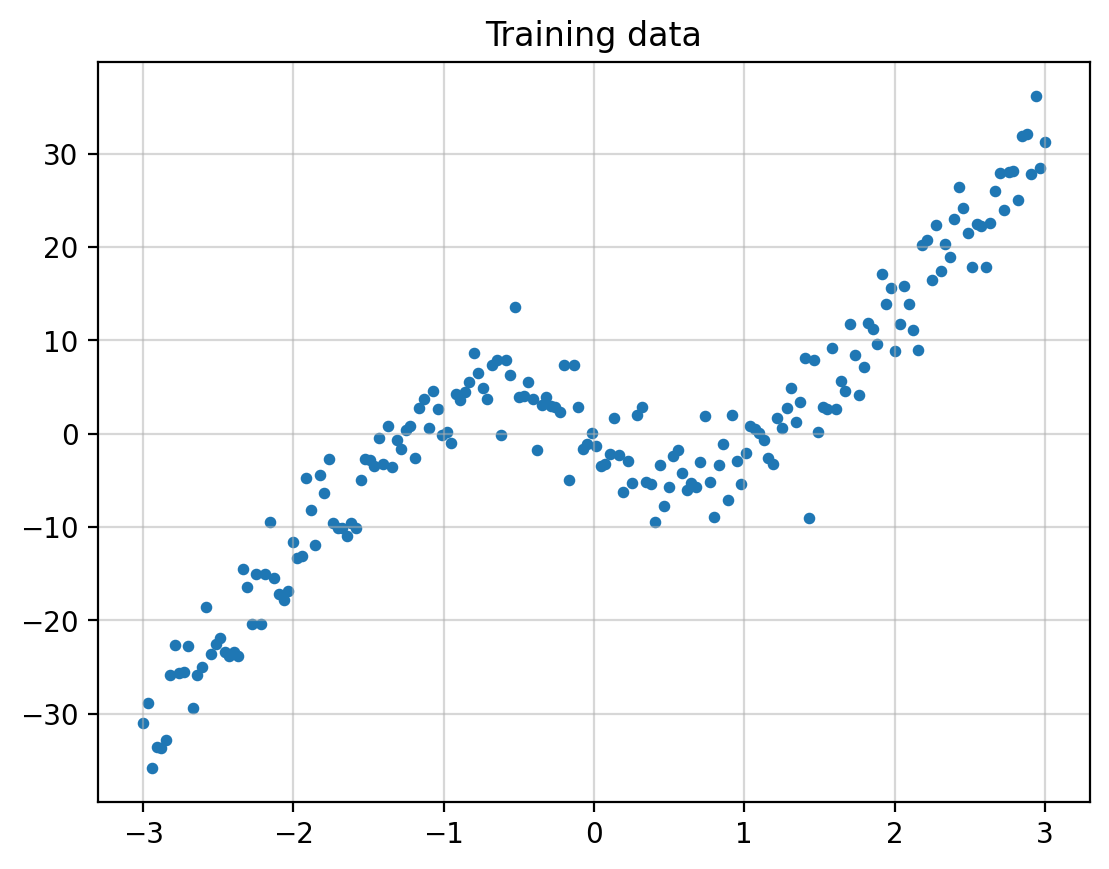

In [364]:
n_obs = 200
xmin, xmax = -3, 3
xnoise, ynoise = 0.0, 3.0
(x, y), (xtest, ytest) = generate_train_test_data(key_sample_obs, f, n_obs,
                                                  xmin, xmax, xnoise, ynoise)
plt.scatter(x, y, s=10)
plt.grid(alpha=0.5)
plt.title("Training data")

## SMC sampling

In [368]:
n_particles = 100
model = MLP(n_hidden=6, n_out=1)
batch = jnp.ones((1, 1))

In [369]:
# q(θ{1})
keys_params_init = jax.random.split(key_params_init, n_particles)
particles_init = jax.vmap(model.init, (0, None))(keys_params_init, batch)
log_weights_init = jnp.zeros((n_particles,))

In [399]:
# Suppose we know the standard deviation of the observations
alpha = 3.0

def smc_step(state, xs):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    new_particles_cond_flat, tree_reconstruct_fn = ravel_pytree(new_particles_cond)
    distr_cond = tfd.Normal(loc=new_particles_cond_flat, scale=0.2)
    particles_next = tree_reconstruct_fn(distr_cond.sample(seed=key_propagate))
    
    # 3. Construct new weights
    mean_obs = jax.vmap(model.apply, (0, None))(particles_next, xobs[None]).ravel()
    dist_obs = tfd.Normal(loc=mean_obs, scale=alpha)
    
    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "log_weights": log_weights_next,
        "particles": particles_next
    }
    
    return state_next, memory

In [400]:
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, x, y)
(_, particles_final), hist = jax.lax.scan(smc_step, init_state, xs)

In [401]:
particles_hist = hist["particles"]
log_weights_hist = hist["log_weights"]

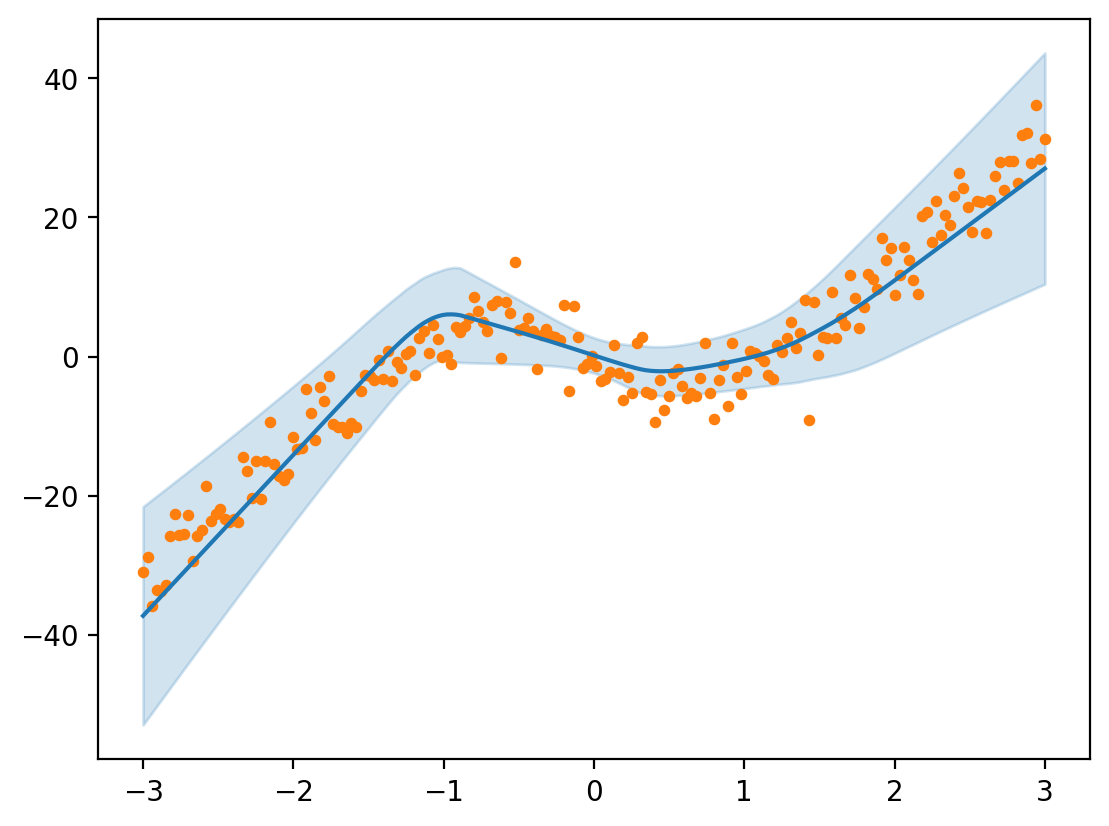

In [416]:
f_particles = jax.vmap(model.apply, (0, None))(particles_final, xtest[:, None])[..., 0]
yhat_mean = f_particles.mean(axis=0)
yhat_std = f_particles.std(axis=0)

plt.plot(xtest, yhat_mean)
plt.fill_between(xtest, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="tab:blue", alpha=0.2)

plt.scatter(x, y, s=10, c="tab:orange")

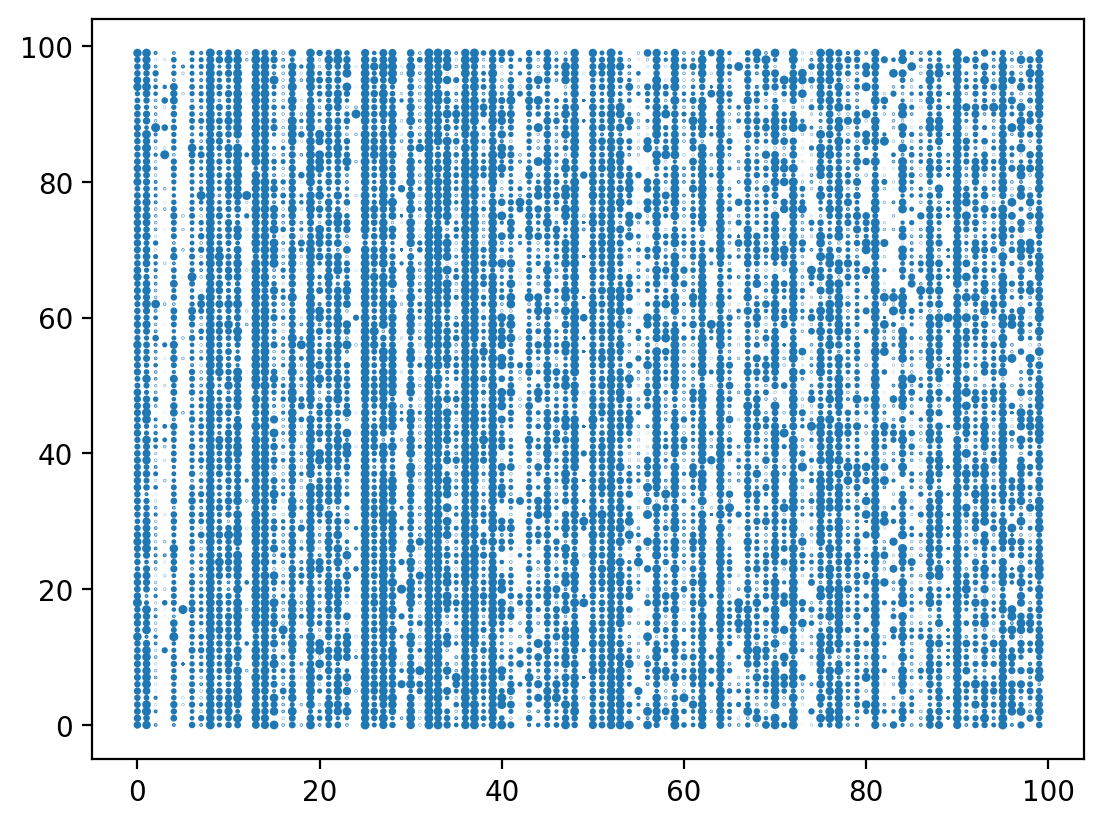

In [418]:
weights = jnp.exp(log_weights_hist - jax.nn.logsumexp(log_weights_hist, axis=1, keepdims=True))
yvals = jnp.arange(n_particles)
for xp, wvec in enumerate(weights[:100]):
    w_rescale = wvec / wvec.max() * 5.0
    plt.scatter(xp * jnp.ones(n_particles), yvals, s=w_rescale, c="tab:blue")